In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from statsmodels.discrete.discrete_model import Logit, MNLogit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import Imputer #to replace mean values
from pyramid.arima import auto_arima #pip install pyramid-arima
from sklearn.preprocessing import label_binarize

## Missing Values

Drop if:
- an observation has "a lot of" missing values
- a variable has "a lot of" missing values
- values are missing at random

Do not drop (fill/impute) if:
- an observation has "only a few" missing values
- a variable has "only a few" missing values
- values are not missing at random

In [99]:
data=pd.read_excel("edu_data.xlsx")

In [100]:
data.head()

,id,gender,ses,schtyp,prog,read,write,math,science,socst,honors,awards,cid
0,45,female,low,public,vocation,34.0,35.0,41.0,29.0,5.0,not enrolled,0.0,1
1,108,male,middle,public,general,34.0,33.0,41.0,36.0,36.0,not enrolled,0.0,1
2,15,male,high,public,vocation,39.0,39.0,44.0,26.0,42.0,not enrolled,0.0,1
3,67,male,low,public,vocation,37.0,37.0,42.0,33.0,32.0,not enrolled,0.0,1
4,153,male,middle,public,vocation,39.0,NaN,40.0,39.0,51.0,not enrolled,NaN,1


In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 13 columns):
id         200 non-null int64
gender     199 non-null object
ses        194 non-null object
schtyp     199 non-null object
prog       199 non-null object
read       197 non-null float64
write      194 non-null float64
math       199 non-null float64
science    198 non-null float64
socst      199 non-null float64
honors     100 non-null object
awards     198 non-null float64
cid        200 non-null int64
dtypes: float64(6), int64(2), object(5)
memory usage: 20.4+ KB


In [102]:
data.isnull().sum()

id           0
gender       1
ses          6
schtyp       1
prog         1
read         3
write        6
math         1
science      2
socst        1
honors     100
awards       2
cid          0
dtype: int64

In [103]:
#first let's drop id 
data.drop("id",axis=1,inplace=True)

### We won't use data.dropna() as we don't want to drop all NAs. We want to drop some of them and do replacing for others.

In [104]:
#As we know which columns have NAs, let's print first 20 rows that have null value
data[data.isnull().any(axis=1)].head(20)

,gender,ses,schtyp,prog,read,write,math,science,socst,honors,awards,cid
4,male,middle,public,vocation,39.0,NaN,40.0,39.0,51.0,not enrolled,NaN,1
7,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,not enrolled,0.0,1
10,female,low,public,vocation,34.0,NaN,40.0,39.0,41.0,not enrolled,0.0,1
11,male,high,public,academic,39.0,33.0,38.0,47.0,41.0,not enrolled,NaN,2
13,female,NaN,public,vocation,NaN,44.0,37.0,42.0,41.0,not enrolled,0.0,2
14,female,low,public,vocation,35.0,35.0,40.0,NaN,33.0,not enrolled,0.0,2
22,female,low,public,vocation,41.0,NaN,40.0,39.0,51.0,not enrolled,0.0,3
35,male,middle,public,vocation,42.0,NaN,39.0,56.0,46.0,not enrolled,0.0,4
46,female,middle,public,vocation,47.0,46.0,NaN,47.0,61.0,not enrolled,0.0,5
50,female,middle,public,academic,NaN,41.0,45.0,44.0,56.0,not enrolled,0.0,5


In [105]:
#First, let's drop column "honor" as it has many missing values (100 out of 200)
data.drop("honors",axis=1, inplace=True)

In [106]:
#let's remove row "7" as majority of values in this row are missing
data.drop(7,axis=0, inplace=True)

In [107]:
#let's print only the rows which have NAs
data[data.isnull().sum(axis=1)>0]

,gender,ses,schtyp,prog,read,write,math,science,socst,awards,cid
4,male,middle,public,vocation,39.0,NaN,40.0,39.0,51.0,NaN,1
10,female,low,public,vocation,34.0,NaN,40.0,39.0,41.0,0.0,1
11,male,high,public,academic,39.0,33.0,38.0,47.0,41.0,NaN,2
13,female,NaN,public,vocation,NaN,44.0,37.0,42.0,41.0,0.0,2
14,female,low,public,vocation,35.0,35.0,40.0,NaN,33.0,0.0,2
22,female,low,public,vocation,41.0,NaN,40.0,39.0,51.0,0.0,3
35,male,middle,public,vocation,42.0,NaN,39.0,56.0,46.0,0.0,4
46,female,middle,public,vocation,47.0,46.0,NaN,47.0,61.0,0.0,5
50,female,middle,public,academic,NaN,41.0,45.0,44.0,56.0,0.0,5
95,female,NaN,private,general,55.0,59.0,52.0,42.0,56.0,2.0,10


In [108]:
#We see that observation (row)4 has only 2 missing values, so instead of dropping let's replace it with median value
#The same let's do awards as well
data['write']=data['write'].fillna(data.write.median()])
data['awards']=data['awards'].fillna(data.awards.median())
data[data.isnull().sum(axis=1)>0]

,gender,ses,schtyp,prog,read,write,math,science,socst,awards,cid
13,female,NaN,public,vocation,NaN,44.0,37.0,42.0,41.0,0.0,2
14,female,low,public,vocation,35.0,35.0,40.0,NaN,33.0,0.0,2
46,female,middle,public,vocation,47.0,46.0,NaN,47.0,61.0,0.0,5
50,female,middle,public,academic,NaN,41.0,45.0,44.0,56.0,0.0,5
95,female,NaN,private,general,55.0,59.0,52.0,42.0,56.0,2.0,10
117,female,NaN,public,academic,63.0,52.0,54.0,50.0,51.0,1.0,12
137,male,NaN,public,academic,54.0,63.0,57.0,55.0,46.0,4.0,14
150,male,NaN,private,academic,55.0,59.0,62.0,58.0,51.0,2.0,15


In [109]:
#for "math", "read" and "science" let's use mean
for i in ["math","read", "science"]:
    data[i]=data[i].fillna(data[i].mean())
data[data.isnull().sum(axis=1)>0]

,gender,ses,schtyp,prog,read,write,math,science,socst,awards,cid
13,female,NaN,public,vocation,52.335025,44.0,37.0,42.0,41.0,0.0,2
95,female,NaN,private,general,55.000000,59.0,52.0,42.0,56.0,2.0,10
117,female,NaN,public,academic,63.000000,52.0,54.0,50.0,51.0,1.0,12
137,male,NaN,public,academic,54.000000,63.0,57.0,55.0,46.0,4.0,14
150,male,NaN,private,academic,55.000000,59.0,62.0,58.0,51.0,2.0,15


In [110]:
#to replace NAs we can use Imputer from sklearn, which is doing the same replacement of NAs with some values(e.g. mean)
##This will look for all columns where we have NaN value and replace the NaN value with specified metric (e.g.mean)
#the code is the following:
#imp = Imputer(missing_values='NaN', strategy='mean', axis=1)
#imp.fit(data)
#data_num= pd.DataFrame(imp.transform(data),columns=data.columns)

In [111]:
#but we can see above thar there is still categorical variable which have NAs
#remaining NAs are in column "ses" which is categorical variable
#let's see the categories
print(data.ses.value_counts())

middle    91
high      56
low       47
Name: ses, dtype: int64


In [112]:
#to handle missing values in ses, we can either include them in majority class (here, middle) or ceate new category
#let's create new category for missing values and name them as "other"
data['ses']=data.ses.fillna("other")
print(data.ses.value_counts())

middle    91
high      56
low       47
other      5
Name: ses, dtype: int64


In [113]:
data_num=data.select_dtypes(exclude="object")

# Outliers

Methods to detect:
- Using Mean and Std
- Using IQR
- Using MAD

In [114]:
# calculate mean and std dev statistics
mean,std_dev = np.mean(data_num),np.std(data_num)
#Let's define upper and lower values, and we want to detect values out of that range
##99.7% of data are within 3 std dev of the mean
lower, upper = mean - 3*std_dev, mean + 3*std_dev
print(lower)
print("\n")
print(upper)

read       21.779450
write      21.369803
math       24.955116
science    22.487253
socst      19.441980
awards     -3.736306
cid        -6.809555
dtype: float64


read       82.890601
write      85.826177
math       80.600439
science    81.401636
socst      85.372090
awards      7.113190
cid        27.764329
dtype: float64


In [115]:
#let's find columns which have outliers
outliers_lower=data_num[data_num<lower].notnull().sum()
outliers_upper=data_num[data_num>upper].notnull().sum()
print(outliers_lower)
print("\n")
print(outliers_upper)

read       0
write      0
math       0
science    0
socst      1
awards     0
cid        0
dtype: int64


read       0
write      2
math       0
science    0
socst      0
awards     0
cid        0
dtype: int64


In [117]:
#example of removing ouliers by using this method
data_num_clean=data_num[data_num["write"]<=upper[1]]

In [118]:
#instead of all these calculations we can use z-score from scipy, the code will be sth like this:
#z = np.abs(scipy.stats.zscore(data_num))
#np.where(z > 3)

## Using IQR for "socst"

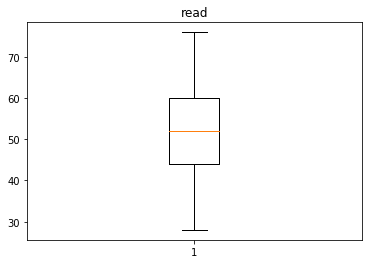

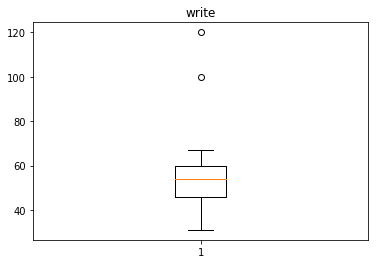

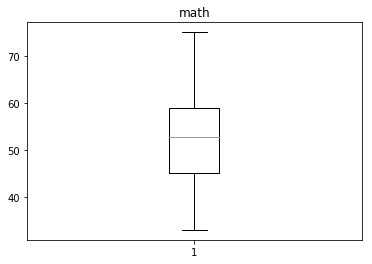

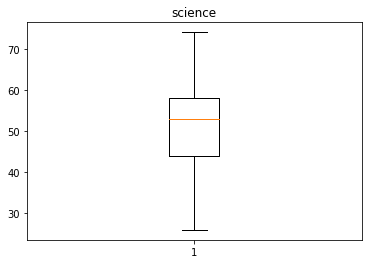

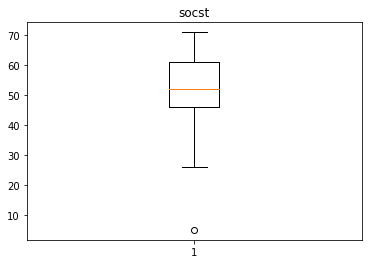

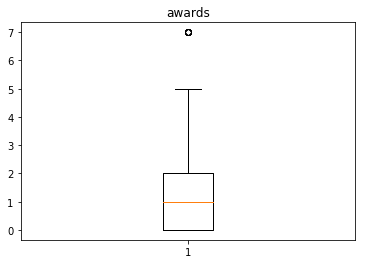

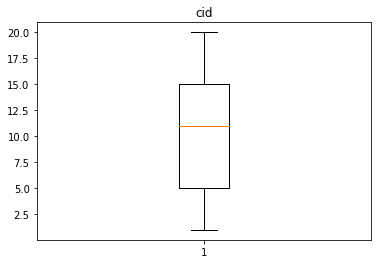

In [119]:
for i in data_num.columns:
    plt.boxplot(data_num[i])
    plt.title(i)
    plt.show()

In [54]:
#example of removing outliers
#Let's do boxplot calculations
#let's calculate 75% quantile (Q3)
Q3=np.percentile(data_num["socst"], 75)
#let's calculate 25% quantile (Q1)
Q1=np.percentile(data_num["socst"], 25)
#the difference between first and third quartiles is IQR
IQR=Q3-Q1
#outliers are out of the following range: [Q1-1.5*IQR; Q3 + 1.5*IQR]
data_num_clean2=data_num[(data_num["socst"]>=Q1-1.5*IQR) & (data_num["socst"]<=Q3+1.5*IQR)]

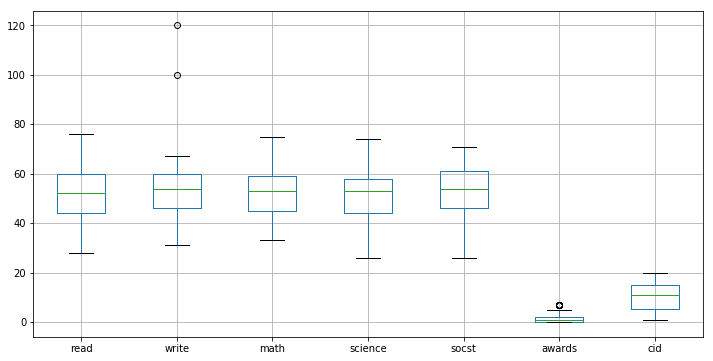

In [122]:
plt.figure(figsize=(12,6))
data_num_clean2.boxplot()
plt.show()

# Multiclass logistic regression

In [56]:
#Y variable is prog
print(data.prog.value_counts())

academic    105
vocation     49
general      45
Name: prog, dtype: int64


In [57]:
#we should recode categories of prog into numeric values to be able to use as Y variable in multv. logit
data.replace({"prog":{"academic": 0, "vocation": 1, "general": 2}}, inplace=True)
data.head()

,gender,ses,schtyp,prog,read,write,math,science,socst,awards,cid
0,female,low,public,1,34.0,35.0,41.0,29.0,5.0,0.0,1
1,male,middle,public,2,34.0,33.0,41.0,36.0,36.0,0.0,1
2,male,high,public,1,39.0,39.0,44.0,26.0,42.0,0.0,1
3,male,low,public,1,37.0,37.0,42.0,33.0,32.0,0.0,1
4,male,middle,public,1,39.0,54.0,40.0,39.0,51.0,1.0,1


In [58]:
data_obj=data.select_dtypes(include="object")
data_dum=pd.get_dummies(data_obj,drop_first=True)
X=data_dum.join(data_num)
Y=data["prog"]
print(X.head())
print("\n")
print(Y.head())

   gender_male  ses_low  ses_middle  ses_other  schtyp_public  read  write  \
0            0        1           0          0              1  34.0   35.0   
1            1        0           1          0              1  34.0   33.0   
2            1        0           0          0              1  39.0   39.0   
3            1        1           0          0              1  37.0   37.0   
4            1        0           1          0              1  39.0   54.0   

   math  science  socst  awards  cid  
0  41.0     29.0    5.0     0.0    1  
1  41.0     36.0   36.0     0.0    1  
2  44.0     26.0   42.0     0.0    1  
3  42.0     33.0   32.0     0.0    1  
4  40.0     39.0   51.0     1.0    1  


0    1
1    2
2    1
3    1
4    1
Name: prog, dtype: int64


In [59]:
#Let's run and fit the model
logit1=MNLogit(Y,X).fit()

Optimization terminated successfully.
         Current function value: 0.782499
         Iterations 6


In [60]:
#let's see the summary
logit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:                   prog   No. Observations:                  199
Model:                        MNLogit   Df Residuals:                      175
Method:                           MLE   Df Model:                           22
Date:                Sat, 08 Dec 2018   Pseudo R-squ.:                  0.2318
Time:                        13:18:01   Log-Likelihood:                -155.72
converged:                       True   LL-Null:                       -202.70
                                        LLR p-value:                 7.167e-11
=================================================================================
       prog=1       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
gender_male      -0.2762      0.479     -0.577      0.564      -1.215       0.663
ses_low          -0.1531      0.683     -0.224      0.823      -1.492       1.186
ses_middle        0.9807      0.564      1.737      0.082      -0.126       2.087
ses_other         0.2330      1.623      0.144      0.886      -2.949       3.415
schtyp_public     1.9046      0.811      2.348      0.019       0.315       3.494
read              0.0113      0.037      0.309      0.757      -0.060       0.083
write             0.0256      0.036      0.716      0.474      -0.044       0.096
math             -0.0625      0.036     -1.754      0.079      -0.132       0.007
science           0.1028      0.037      2.802      0.005       0.031       0.175
socst            -0.0808      0.029     -2.787      0.005      -0.138      -0.024
awards           -0.0034      0.278     -0.012      0.990      -0.548       0.542
cid              -0.2690      0.100     -2.685      0.007      -0.465      -0.073
---------------------------------------------------------------------------------
       prog=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
gender_male      -0.1930      0.444     -0.434      0.664      -1.064       0.678
ses_low           0.9481      0.592      1.600      0.110      -0.213       2.109
ses_middle        0.5909      0.514      1.150      0.250      -0.417       1.598
ses_other         0.9555      1.335      0.716      0.474      -1.661       3.572
schtyp_public     0.5889      0.560      1.051      0.293      -0.509       1.687
read             -0.0238      0.033     -0.727      0.467      -0.088       0.040
write            -0.0269      0.036     -0.747      0.455      -0.097       0.044
math             -0.0738      0.033     -2.229      0.026      -0.139      -0.009
science           0.1338      0.036      3.739      0.000       0.064       0.204
socst            -0.0167      0.027     -0.620      0.535      -0.069       0.036
awards            0.0989      0.218      0.453      0.651      -0.329       0.527
cid              -0.1361      0.089     -1.524      0.127      -0.311       0.039
=================================================================================
"""

In [61]:
#let's get marginal effects
logit1.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       MNLogit Marginal Effects      
=====================================
Dep. Variable:                   prog
Method:                          dydx
At:                           overall
=================================================================================
       prog=0      dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
gender_male       0.0385      0.064      0.598      0.550      -0.088       0.165
ses_low          -0.0785      0.086     -0.908      0.364      -0.248       0.091
ses_middle       -0.1278      0.072     -1.785      0.074      -0.268       0.013
ses_other        -0.1076      0.203     -0.531      0.596      -0.505       0.290
schtyp_public    -0.1954      0.084     -2.328      0.020      -0.360      -0.031
read              0.0014      0.005      0.291      0.771      -0.008       0.011
write             0.0007      0.005      0.133      0.895      -0.009       0.011
math              0.0116      0.005      2.437      0.015       0.002       0.021
science          -0.0202      0.005     -4.488      0.000      -0.029      -0.011
socst             0.0075      0.004      1.944      0.052   -6.17e-05       0.015
awards           -0.0091      0.033     -0.277      0.782      -0.074       0.055
cid               0.0326      0.012      2.655      0.008       0.009       0.057
---------------------------------------------------------------------------------
       prog=1      dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
gender_male      -0.0253      0.059     -0.431      0.667      -0.140       0.090
ses_low          -0.0779      0.083     -0.937      0.349      -0.241       0.085
ses_middle        0.0955      0.070      1.358      0.174      -0.042       0.233
ses_other        -0.0267      0.202     -0.132      0.895      -0.422       0.369
schtyp_public     0.2193      0.102      2.141      0.032       0.019       0.420
read              0.0030      0.004      0.679      0.497      -0.006       0.011
write             0.0051      0.004      1.162      0.245      -0.003       0.014
math             -0.0039      0.004     -0.951      0.342      -0.012       0.004
science           0.0057      0.004      1.412      0.158      -0.002       0.014
socst            -0.0098      0.003     -3.121      0.002      -0.016      -0.004
awards           -0.0064      0.036     -0.180      0.857      -0.077       0.064
cid              -0.0278      0.012     -2.392      0.017      -0.051      -0.005
---------------------------------------------------------------------------------
       prog=2      dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
gender_male      -0.0132      0.063     -0.209      0.834      -0.137       0.111
ses_low           0.1565      0.083      1.882      0.060      -0.006       0.319
ses_middle        0.0323      0.075      0.433      0.665      -0.114       0.179
ses_other         0.1343      0.193      0.694      0.487      -0.245       0.513
schtyp_public    -0.0239      0.087     -0.276      0.783      -0.194       0.146
read             -0.0044      0.004     -0.975      0.329      -0.013       0.004
write            -0.0057      0.005     -1.130      0.258      -0.016       0.004
math             -0.0077      0.004     -1.760      0.078      -0.016       0.001
science           0.0145      0.004      3.239      0.001       0.006       0.023
socst             0.0023      0.004      0.658      0.511      -0.005       0.009
awards            0.0156      0.033      0.467      0.641      -0.050       0.081
cid              -0.0048      0.012     -0.400      0.689      -0.029       0.019
========================================================================

# Multiclass Logit from statsmodel

In [62]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [63]:
gridsearch=GridSearchCV(LogisticRegression(multi_class="multinomial",penalty="l2",solver="newton-cg",random_state=42,class_weight="balanced"), 
                        param_grid={"C":np.linspace(0.0001,50,20)},
                        cv=5, n_jobs=-1).fit(X,Y)
#scoring!=roc_auc as roc_auc score cannot be calculated for multiclass

In [64]:
gridsearch.best_params_

{'C': 0.0001}

In [65]:
logit2=LogisticRegression(multi_class="multinomial",penalty="l2",solver="newton-cg",random_state=42,C=0.0001)
logit2.fit(x_train,y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=42, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)

In [66]:
print("Train:", logit2.score(x_train,y_train).round(2))
print("Test:", logit2.score(x_test,y_test).round(2))

Train: 0.6
Test: 0.56


In [133]:
y_score=logit2.predict_proba(x_test)
# Binarize the output
y_test_bi = label_binarize(y_test, classes=[0, 1, 2])
roc_auc=roc_auc_score(y_test_bi.ravel(), y_score.ravel(),average="micro")
print("roc_auc",roc_auc)
print("recall",recall_score(y_test,logit2.predict(x_test),average=None).round(2))

roc_auc 0.7236
recall [0.96 0.3  0.  ]


In [68]:
print(classification_report(y_test,logit2.predict(x_test)))

             precision    recall  f1-score   support

          0       0.58      0.96      0.72        26
          1       0.43      0.30      0.35        10
          2       0.00      0.00      0.00        14

avg / total       0.39      0.56      0.45        50



C:\Users\HP\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [69]:
confusion_matrix(y_test,logit2.predict(x_test)).T

array([[25,  7, 11],
       [ 1,  3,  3],
       [ 0,  0,  0]], dtype=int64)

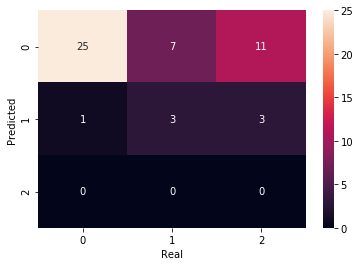

In [70]:
sns.heatmap(confusion_matrix(y_test,logit2.predict(x_test)).T,annot=True)
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.show()

# ARIMA

In [71]:
data_time=pd.read_csv("AirPassengers.csv")
data_time.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [72]:
data_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
Month          144 non-null object
#Passengers    144 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.3+ KB


In [73]:
data_time.isnull().sum() #no missing values

Month          0
#Passengers    0
dtype: int64

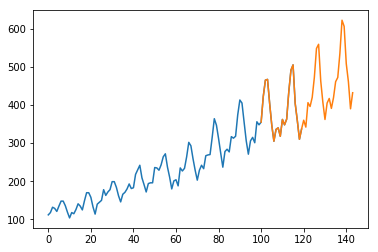

In [74]:
#I want to construct ARIMA model on blue part and forcast on yellow part
data_time["#Passengers"][0:120].plot()
data_time["#Passengers"][100:144].plot()
plt.show()

In [127]:
model = auto_arima(data_time["#Passengers"][0:120], trace=True, error_action='ignore', suppress_warnings=True,)
results=model.fit(data_time["#Passengers"][0:120])

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1087.029, BIC=1103.704, Fit time=0.294 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1140.292, BIC=1145.850, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=1132.336, BIC=1140.673, Fit time=0.040 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1128.668, BIC=1137.006, Fit time=0.079 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1106.793, BIC=1120.689, Fit time=0.119 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=1098.586, BIC=1118.040, Fit time=0.330 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1099.003, BIC=1112.898, Fit time=0.258 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=1126.948, BIC=1138.064, Fit time=0.100 seconds
Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 0, 

In [128]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -534.059
Date:                Sat, 08 Dec 2018   AIC                           1084.119
Time:                        13:40:46   BIC                           1106.352
Sample:                             0   HQIC                          1093.147
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0604      0.387      2.743      0.006       0.303       1.818
ar.L1          0.8235      0.097      8.458      0.000       0.633       1.014
ar.L2          0.4238      0.141      3.008      0.003       0.148       0.700
ar.L3         -0.7188      0.085     -8.453      0.000      -0.885      -0.552
ma.L1         -0.8853     33.457     -0.026      0.979     -66.460      64.690
ma.L2         -0.9059     63.071     -0.014      0.989    -124.523     122.711
ma.L3          0.9794     32.759      0.030      0.976     -63.228      65.186
sigma2       429.8762   1.44e+04      0.030      0.976   -2.77e+04    2.86e+04
===================================================================================
Ljung-Box (Q):                      227.18   Jarque-Bera (JB):                 0.09
Prob(Q):                              0.00   Prob(JB):                         0.96
Heteroskedasticity (H):               6.03   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

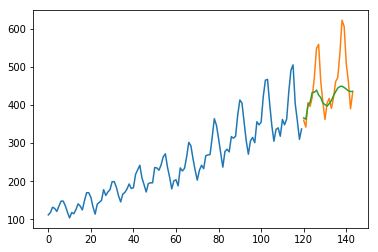

In [76]:
forecast = model.predict(n_periods=len(data_time["#Passengers"][120:144]))
forecast = pd.DataFrame(forecast,index = data_time["#Passengers"][120:144].index,columns=['Prediction'])
#plot the predictions for validation set
plt.plot(data_time["#Passengers"][0:120])
plt.plot(data_time["#Passengers"][120:144])
plt.plot(forecast, label='Prediction')
plt.show()